In [1]:
import mysql.connector as mariadb
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation_script_pdss import *
from query_batch import *

import matplotlib.dates as mdates

from datetime import datetime, timedelta

import csv
import os
from pathlib import Path
import glob
import time

plt.rcParams['font.sans-serif'] = ['sans-serif']

2024-04-09 11:34:18.352688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 11:34:18.607320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 11:34:18.607365: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 11:34:20.599348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
def load_device(model, device_id, window_size):
    #convert s to samples
    window_size = str(window_size*125)
    path = f'prospective_results_pdss/{model}/{window_size}/{device_id}.csv'
    
    file = open(path, "r")
    data_list = list(csv.reader(file, delimiter=","))
    file.close()
    
    return data_list


#all units shoule be in seconds
def preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method="gaussian"):
    merged = dict_merge([(int(start), int(stop), float(sigmoid)) for (start, stop, sigmoid) in data_list])#skip header

    smoothed= smooth_discontinuous_sorted(merged, window_size, new_slide, smoothing_method)
    return smoothed, merged


def time_plot(processed_dict, key):
    subset = processed_dict[key]
    sigmoids = [x[2] for x in subset]
    times = [x[0] for x in subset]
    if len(times)>2:
        converted_times = [datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S') for time in times]
        data = {"sigmoid_score":sigmoids, "time":times}
        print(datetime.fromtimestamp(times[0]).strftime('%Y-%m-%d %H:%M:%S'))
        print(datetime.fromtimestamp(times[-1]).strftime('%Y-%m-%d %H:%M:%S'))
        plt.figure()
        sns.set(rc={"figure.figsize":(20, 5)})
        sns.scatterplot(data=data, x="time", y="sigmoid_score")
        plt.show()
        

In [3]:
def get_patients(stitched_predictions):
    regions = []
    current_region = [epoch_to_datetime(stitched_predictions[0][0][0])]
    
    combined_predictions = []
    
    for pred_type in stitched_predictions:
        for start,stop in pred_type:
            combined_predictions.append((start,stop))
            
    combined_predictions = sorted(combined_predictions, key=lambda x: x[0])

    for start,stop in combined_predictions:
        start_dt, stop_dt = epoch_to_datetime(start), epoch_to_datetime(stop)

        if start_dt - current_region[-1] > timedelta(hours=14):
            regions.append(current_region)
            current_region = [start_dt]

        current_region.append(stop_dt)

    if current_region:
        regions.append(current_region)

    regions_dict = {}
    for region in regions:
        key = (region[0], region[-1])
        regions_dict[key] = []

        for pred_type, label in zip(stitched_predictions, ['pos', 'neg']):
            for start, stop in pred_type:
                start_dt, stop_dt = epoch_to_datetime(start), epoch_to_datetime(stop)
                if start_dt >= region[0] and stop_dt <= region[-1]:
                    regions_dict[key].append((start_dt, stop_dt, label))

    return regions_dict


def plot_patient_intervals_no_ax(region_key, prediction_intervals):
    # Define pastel colors
    pastel_green = '#77dd77'
    pastel_red = '#ff6961'

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(15, 2))

    # Extract the start and end times of the region
    region_start, region_end = region_key
    
    if (region_end - region_start).total_seconds()/3600 >2:

        for start_dt, stop_dt, label in prediction_intervals:
            # Calculate start and stop hours relative to the region start
            start_hours = (start_dt - region_start).total_seconds() / 3600
            stop_hours = (stop_dt - region_start).total_seconds() / 3600

            # Determine color based on the prediction label
            color = pastel_green if label == 'pos' else pastel_red

            # Plot the interval
            ax.plot([start_hours, stop_hours], [1, 1], color=color, linewidth=20, solid_capstyle='butt')

        # Set x-axis limits and ticks
        region_end_hours = (region_end - region_start).total_seconds() / 3600
        ax.set_xlim(0, region_end_hours)
        ax.set_xticks(np.arange(0, region_end_hours + 1, 6))
        ax.set_xticklabels(['{:.0f}h'.format(tick) for tick in np.arange(0, region_end_hours + 1, 6)])

        # Hide the y-axis
        ax.set_yticks([])

        plt.tight_layout()
        plt.show()



In [4]:
# Open the JSON file for reading
with open('prospective_results_pdss/unique_device_measure_pairs.json', 'r') as file:
    # Load the JSON content from the file into a Python dictionary
    unique_values = json.load(file)

    

# By Bed

In [5]:
directory = "prospective_results_pdss/"

In [6]:
unique_beds = set()
unique_measures = set()

for model in ["abp","cvp"]:
    # Collect all relevant files first to use tqdm accurately
    files = [f for f in os.listdir(directory+model+"/7500/") if f.endswith('.csv')]

    # Processing files with a progress bar
    for filename in (files):
        bed = filename.split('_')[0]
        device = '_'.join(filename[:-4].split('_')[1:])

        unique_beds.add(bed)
        unique_measures.add(device)
        
high_acuity = ["84", "85", "86", "87", "88", "89", "90", "91"]
low_acuity = list(unique_beds)  # Assuming unique_beds is a list or set of bed identifiers


In [7]:


# Assuming unique_beds and other necessary variables and functions are defined
#results_dict = {}

# for bed in high_acuity:
#     if bed in low_acuity:
#         low_acuity.remove(bed)

# sample = random.sample(low_acuity, 8)

# for bed in tqdm(high_acuity+low_acuity):
#     bed_metrics = {"abp": [], "cvp": []}
#     for model in ["abp", "cvp"]:
#         directory_path = directory+model+"/7500/"  # Adjust 'directory' as per your setup
#         files = [f for f in os.listdir(directory_path) if f.endswith('.csv') and bed in f]
        
#         for measure_file in files:
#             measure = measure_file[:-4]  # Extract measure name without '.csv'
#             # Load CSV for model + Bed + Measure
#             data_list = load_device(model, measure, 60)  # Assuming these functions are defined
            

#             smoothed, _ = preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method)
#             pos_predictions, neg_predictions = stitch_predictions(smoothed, tolerance=30, threshold=0.5)
            
#             num_pos = len(pos_predictions)
#             if num_pos > 2:
#                 duration_pos = sum(stop-start for (start, stop) in pos_predictions)
#                 total_duration = duration_pos + sum(stop-start for (start, stop) in neg_predictions)
                
#                 if total_duration != 0:
#                     period = num_pos/total_duration
#                     freq = 1/period
#                 else:
#                     freq = 0
                    
#                 if bed in high_acuity:
#                     acuity = "High"
#                 else:
#                     acuity = "Low"
                
#                 bed_metrics[model].append({
#                     "Measure": measure,
#                     "NumPos": num_pos,
#                     "FreqPos": freq,
#                     "TotalDuration": total_duration,
#                     "Acuity": acuity
#                 })
#             else:
#                 continue
                
#     results_dict[bed] = bed_metrics


In [8]:

def prepare_data_for_plotting(results_dict):
    # Initialize an empty list to store the flattened data
    data = []
    # Iterate through each bed and its metrics in the results_dict
    for bed, models in results_dict.items():
        for model, measures in models.items():
            for measure_info in measures:
                # Append each metric as a separate row in the data list
                data.append({
                    "Bed": bed,
                    "Model": model,
                    "Acuity": measure_info["Acuity"],
                    "Measure": measure_info["Measure"],
                    "FreqPos": 1/(measure_info["FreqPos"]/3600),
                    #"DurationPos": measure_info["DurationPos"] / 60,  # Convert to minutes
                    "TotalDuration": measure_info["TotalDuration"] / 3600  # Convert to hours
                })
    # Convert the list of data into a DataFrame
    return pd.DataFrame(data)



In [9]:
def plot_cvp_metric_by_measure(data, y_metric, title):
    # Filter data for the 'cvp' model only
    cvp_data = data[data['Model'] == 'cvp']
    
    plt.figure(figsize=(20, 10))  # Adjust figure size as needed
    sns.boxplot(data=data, x='Model', y=y_metric, hue='Acuity', showfliers=False, palette="Set3")
    # Overlay individual points
    sns.stripplot(data=data, x='Model', y=y_metric, hue='Acuity', color='black', dodge=True, size=5, alpha=0.5)
    
    plt.title(title)
    plt.ylabel(y_metric)
    plt.xlabel('Acuity Level')
    plt.xticks(rotation=45)
    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for i, label in enumerate(labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])
    plt.legend(unique_handles, unique_labels, title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [10]:
# # Prepare the data for plotting if not already done
# df = prepare_data_for_plotting(results_dict)

# # Assuming df is your DataFrame prepared previously
# df['Measure'] = df['Measure'].apply(lambda x: '_'.join(x.split('_')[1:]))

# # Alternatively, if measure names always follow the pattern "xx_abc",
# # you can use slicing: lambda x: x.split('_', 1)[1]


# # Plotting Number of Positive Predictions for 'cvp' model with measures as hues
# plot_cvp_metric_by_measure(df, 'TotalDuration', '')


# By Patient

In [11]:
def stitch_into_patients(pos_predictions, neg_predictions, bed):
    # Combine and sort predictions
    all_predictions = sorted(pos_predictions + neg_predictions, key=lambda x: x[0])

    # Initialize variables for stitching
    patients = {}
    patient_start = None
    patient_stop = None
    patient_index = 1

    for start, stop in all_predictions:
        # If this is the first interval, initialize patient_start and patient_stop
        if patient_start is None:
            patient_start = start
            patient_stop = stop
        else:
            # Check if the current interval starts more than 12 hours after the last interval ended
            if start - patient_stop > 12 * 3600:  # 12 hours in seconds
                # Save the previous patient's interval
                patients[f"{bed}_{patient_index}"] = (patient_start, patient_stop)
                # Start a new patient interval
                patient_index += 1
                patient_start = start
                patient_stop = stop
            else:
                # If within 12 hours, extend the current patient's interval
                patient_stop = max(patient_stop, stop)
    
    # Save the last patient's interval if not already saved
    if patient_start is not None and (f"{bed}_{patient_index}" not in patients):
        patients[f"{bed}_{patient_index}"] = (patient_start, patient_stop)

    return patients


def merge_global_patients(bed, local_patient, measure, num_pos, total_duration):
    global patient_intervals
    local_start, local_stop = local_patient
    patient_found = False

    for global_key, (global_interval, measures, metrics) in patient_intervals.items():
        if global_key.startswith(f"{bed}_"):
            g_start, g_stop = global_interval
            # Check for overlap
            if not (local_stop < g_start or local_start > g_stop):
                # Merge intervals and update metrics
                new_start = min(g_start, local_start)
                new_stop = max(g_stop, local_stop)
                updated_measures = measures + [measure] if measure not in measures else measures
                updated_metrics = {
                    "NumPos": metrics["NumPos"] + num_pos,
                    "TotalDuration": metrics["TotalDuration"] + total_duration
                }
                patient_intervals[global_key] = ((new_start, new_stop), updated_measures, updated_metrics)
                patient_found = True
                break

    # Create a new patient if no overlap was found
    if not patient_found:
        new_index = 1 + max([int(k.split("_")[1]) for k in patient_intervals.keys() if k.startswith(bed)] + [0])
        new_global_key = f"{bed}_{new_index}"
        patient_intervals[new_global_key] = ((local_start, local_stop), [measure], {"NumPos": num_pos, "TotalDuration": total_duration})


In [12]:
current_slide = 5
new_slide = 5
smoothing_method = "gaussian"

In [13]:
# for window_size in [20,60]:
#     patient_intervals = {}

#     for bed in tqdm(high_acuity + low_acuity):
#         for model in ["abp", "cvp"]:
#             directory_path = directory + model + "/"+str(window_size*125)+"/"
#             files = [f for f in os.listdir(directory_path) if f.endswith('.csv') and bed in f]

#             for measure_file in files:
#                 measure = measure_file[:-4]
#                 data_list = load_device(model, measure, window_size)[1:]

#                 smoothed, _ = preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method)
#                 pos_predictions, neg_predictions = stitch_predictions(smoothed, tolerance=30, threshold=0.5)

#                 num_pos = len(pos_predictions)
#                 if num_pos > 2:
#                     duration_pos = sum(stop - start for (start, stop) in pos_predictions)
#                     total_duration = duration_pos + sum(stop - start for (start, stop) in neg_predictions)

#                     if total_duration != 0:
#                         freq = num_pos / (total_duration / 3600)  # Converting seconds to hours for frequency calculation

#                     # Stitch into local patients (modified to return only one interval for simplicity)
#                     local_patients = stitch_into_patients(pos_predictions, neg_predictions, bed)
#                     for _, interval in local_patients.items():
#                         merge_global_patients(bed, interval, measure, num_pos, total_duration)

#     # Assuming patient_intervals is your global dictionary
#     with open('patient_intervals_'+str(window_size *125)+'.pkl', 'wb') as handle:
#         pkl.dump(patient_intervals, handle, protocol=pkl.HIGHEST_PROTOCOL)


In [14]:
window_size = 60

with open('patient_intervals_'+str(window_size *125) +'.pkl', 'rb') as handle:
    patient_intervals = pkl.load(handle)



In [15]:
def model_from_measure(measure,window_size=60):
    directory_path = directory+"abp"+"/"+str(window_size*125)+"/"  # Adjust 'directory' as per your setup
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    if str(measure+".csv") in files:

        return "abp"

    else:
        return "cvp"
    

In [16]:
# patients = []
# all_measures = []
# models = []
# total_durations = []
# acuities = []
# num_positives = []
# frequencies = []
# intervals = []



# for patient_id, ((start,stop), measures, _) in tqdm(patient_intervals.items()):
#     # Determine bed and acuity from patient_id
#     bed = patient_id.split('_')[0]
#     acuity = "High" if bed in high_acuity else "Low"
    
#     for model in ["abp", "cvp"]:
        
#         for measure in measures: #Load the right CSV
#             if model_from_measure(measure) == model:
#                 data_list = load_device(model, measure, window_size)[1:] #remove header
#                 data_list = [(a,b,c) for (a,b,c) in data_list if (int(a)>=int(start) and int(b)<=int(stop))]
                
#                 smoothed, _ = preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method)
                

#                 pos_predictions, neg_predictions = stitch_predictions(smoothed, tolerance=30, threshold=0.5)
            
#                 num_pos = len(pos_predictions)
                
#                 if num_pos>0:
#                     duration_pos = sum(stop-start for (start, stop) in pos_predictions)
#                     total_duration = duration_pos +  sum(stop-start for (start, stop) in neg_predictions)

#                     if total_duration != 0:
#                         period = num_pos/(total_duration/3600)
#                         freq = 1/period
#                     else:
#                         freq = 0

#                     patients.append(patient_id)
#                     all_measures.append(measure)
#                     models.append(model)
#                     total_durations.append(total_duration)
#                     acuities.append(acuity)
#                     num_positives.append(num_pos)
#                     frequencies.append(freq)
#                     intervals.append((start,stop))
#                 else:
#                     continue
#             else:
#                 continue




In [17]:
# # Organize your data into a dictionary
# data = {
#     'PatientID': patients,
#     'Measure': all_measures,
#     'Model': models,
#     'TotalDuration': total_durations,
#     'Acuity': acuities,
#     'NumPositives': num_positives,
#     'Frequency': frequencies,
#     'Intervals': intervals
# }

# # Create the DataFrame
# results_df = pd.DataFrame(data)
# results_df.to_csv('results_'+str(window_size*125)+'.csv', index=False)


# results_df

In [68]:
results_df = pd.read_csv('results_'+str(window_size*125)+'.csv')

results_df['Intervals'] = results_df['Intervals'].apply(lambda x: eval(x))
# Convert 'TotalDuration' from seconds to days for all relevant plots
results_df['TotalDurationDays'] = results_df['TotalDuration'] / (24 * 3600)
results_df['TotalDurationHours'] = results_df['TotalDuration'] / (3600)
results_df['Frequency'] = results_df['NumPositives'] / results_df['TotalDurationHours']
results_df['LOS'] = results_df['Intervals'].apply(lambda x: (((x)[1]) - ((x)[0])) / (24 * 3600))


# Convert the epoch times to datetime and find the months they belong to
results_df['start_month'] = pd.to_datetime(results_df['Intervals'].apply(lambda x: x[0]), unit='s').dt.to_period('M')
results_df['end_month'] = pd.to_datetime(results_df['Intervals'].apply(lambda x: x[1]), unit='s').dt.to_period('M')


# Convert the epoch times to datetime and find the months they belong to
results_df['start_week'] = pd.to_datetime(results_df['Intervals'].apply(lambda x: x[0]), unit='s').dt.to_period('W')
results_df['end_week'] = pd.to_datetime(results_df['Intervals'].apply(lambda x: x[1]), unit='s').dt.to_period('W')


# A function to generate a list of months between two months
def months_in_range(start, end):
    return [str(m) for m in pd.period_range(start=start, end=end, freq='M')]


# A function to generate a list of months between two months
def weeks_in_range(start, end):
    return [str(m) for m in pd.period_range(start=start, end=end, freq='2W')]

# Apply the function to each row and explode the DataFrame
results_df['all_months'] = results_df.apply(lambda x: months_in_range(x['start_month'], x['end_month']), axis=1)
results_df['all_weeks'] = results_df.apply(lambda x: weeks_in_range(x['start_month'], x['end_month']), axis=1)
results_df_months = results_df.explode('all_months')
results_df_weeks = results_df.explode('all_weeks')


In [74]:
results_df

,PatientID,Measure,Model,TotalDuration,Acuity,NumPositives,Frequency,Intervals,TotalDurationDays,TotalDurationHours,LOS,start_month,end_month,start_week,end_week,all_months,all_weeks
0,84_1,84_MDC_PRESS_BLD_ART,abp,34681,High,1,0.103803,"(1696132801, 1696167482)",0.401400,9.633611,0.401400,2023-10,2023-10,2023-09-25/2023-10-01,2023-09-25/2023-10-01,[2023-10],[2023-10-30/2023-11-05]
1,84_1,84_MDC_PRESS_BLD_VEN_CENT,cvp,34681,High,6,0.622819,"(1696132801, 1696167482)",0.401400,9.633611,0.401400,2023-10,2023-10,2023-09-25/2023-10-01,2023-09-25/2023-10-01,[2023-10],[2023-10-30/2023-11-05]
2,84_2,84_MDC_PRESS_BLD_ART,abp,373845,High,13,0.125186,"(1696229581, 1696603426)",4.326910,103.845833,4.326910,2023-10,2023-10,2023-10-02/2023-10-08,2023-10-02/2023-10-08,[2023-10],[2023-10-30/2023-11-05]
3,84_2,84_MDC_PRESS_BLD_VEN_CENT,cvp,373845,High,14,0.134815,"(1696229581, 1696603426)",4.326910,103.845833,4.326910,2023-10,2023-10,2023-10-02/2023-10-08,2023-10-02/2023-10-08,[2023-10],[2023-10-30/2023-11-05]
4,84_3,84_MDC_PRESS_BLD_ART,abp,68581,High,2,0.104985,"(1696798976, 1696867557)",0.793762,19.050278,0.793762,2023-10,2023-10,2023-10-02/2023-10-08,2023-10-09/2023-10-15,[2023-10],[2023-10-30/2023-11-05]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,102_3,102_MDC_PRESS_BLD_ART,abp,224795,Low,7,0.112102,"(1704851306, 1705076101)",2.601794,62.443056,2.601794,2024-01,2024-01,2024-01-08/2024-01-14,2024-01-08/2024-01-14,[2024-01],[2024-01-29/2024-02-04]
641,102_4,102_MDC_PRESS_BLD_ART,abp,46980,Low,3,0.229885,"(1705186886, 1705233866)",0.543750,13.050000,0.543750,2024-01,2024-01,2024-01-08/2024-01-14,2024-01-08/2024-01-14,[2024-01],[2024-01-29/2024-02-04]
642,102_5,102_MDC_PRESS_BLD_ART,abp,159575,Low,2,0.045120,"(1706564179, 1706723754)",1.846933,44.326389,1.846933,2024-01,2024-01,2024-01-29/2024-02-04,2024-01-29/2024-02-04,[2024-01],[2024-01-29/2024-02-04]
643,102_6,102_MDC_PRESS_BLD_VEN_CENT,cvp,122940,Low,6,0.175695,"(1696132804, 1696255744)",1.422917,34.150000,1.422917,2023-10,2023-10,2023-09-25/2023-10-01,2023-10-02/2023-10-08,[2023-10],[2023-10-30/2023-11-05]


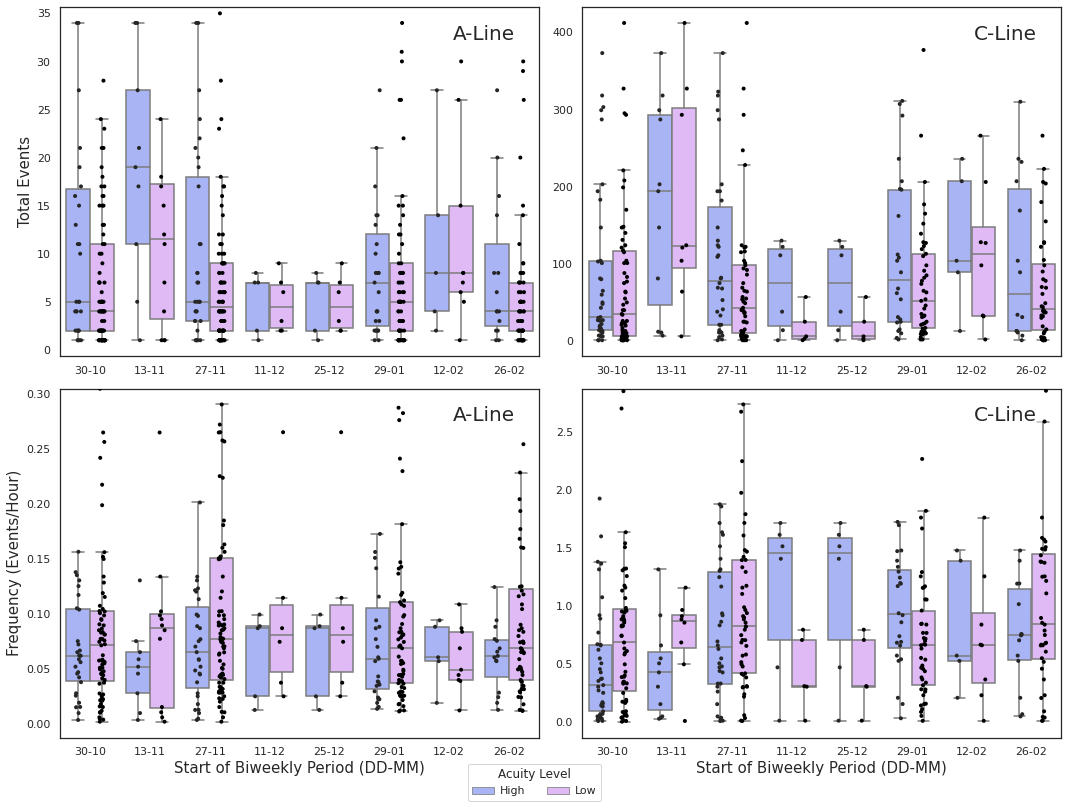

In [75]:

# Your initial setup remains unchanged
custom_titles = {
    'abp': '',
    'cvp': ''
}
custom_xlabels = 'Start of Biweekly Period (DD-MM)'
custom_ylabels = {
    'NumPositives': 'Total Events',
    'Frequency': 'Frequency (Events/Hour)'
}
custom_legend_title = 'Acuity Level'

df = results_df_weeks  # Your DataFrame should be defined earlier in the code
x = "all_weeks"

acuity_colors = {
    'High': '#9CACFF',
    'Low': '#E2B0FF'
}

sns.set(font="sans-serif")
sns.set_style("white")

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted for potentially better layout

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Loop through each metric and model combination
panel_labels = ["A-Line", "C-Line", "A-Line", "C-Line"]  # Example annotations
for idx, (y, model) in enumerate([('NumPositives', 'abp'), ('NumPositives', 'cvp'), ('Frequency', 'abp'), ('Frequency', 'cvp')]):
    ax = sns.boxplot(data=df[df["Model"]==model], 
                     x=x, y=y, hue='Acuity', showfliers=False, ax=axs[idx], palette=acuity_colors)
    ylims = ax.get_ylim()
    sns.stripplot(data=df[df["Model"]==model], 
                  x=x, y=y, hue='Acuity', color='black', size=4, jitter=True, dodge=True, ax=axs[idx])
    ax.set(ylim=ylims)
    if model == 'abp':
        ax.set_ylabel(custom_ylabels[y], fontsize=15)
    else:
        ax.set_ylabel('')
    ax.set_title(custom_titles[model])
    if y =="NumPositives":
        ax.set_xlabel('')
    else:
        ax.set_xlabel(custom_xlabels, fontsize=15)
    ax.legend_.remove()  # Remove the auto-generated legend
    new_labels = [label.get_text()[5:10] for label in ax.get_xticklabels()]
    new_labels = [ label[3:] + "-" + label[:2] for label in new_labels] #DD-MM format
    ax.set_xticklabels(new_labels)
    
    # Add annotation in the top right corner of each subplot
    ax.text(0.95, 0.95, panel_labels[idx], transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5))

# Adjust the layout and the rest of the code as before
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
handles, labels = axs[-1].get_legend_handles_labels()
legend = fig.legend(handles[:2], labels[:2], loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3, title=custom_legend_title, handletextpad=0.5)
legend.get_title().set_ha("center")
plt.savefig('over_time.pdf')
plt.show()


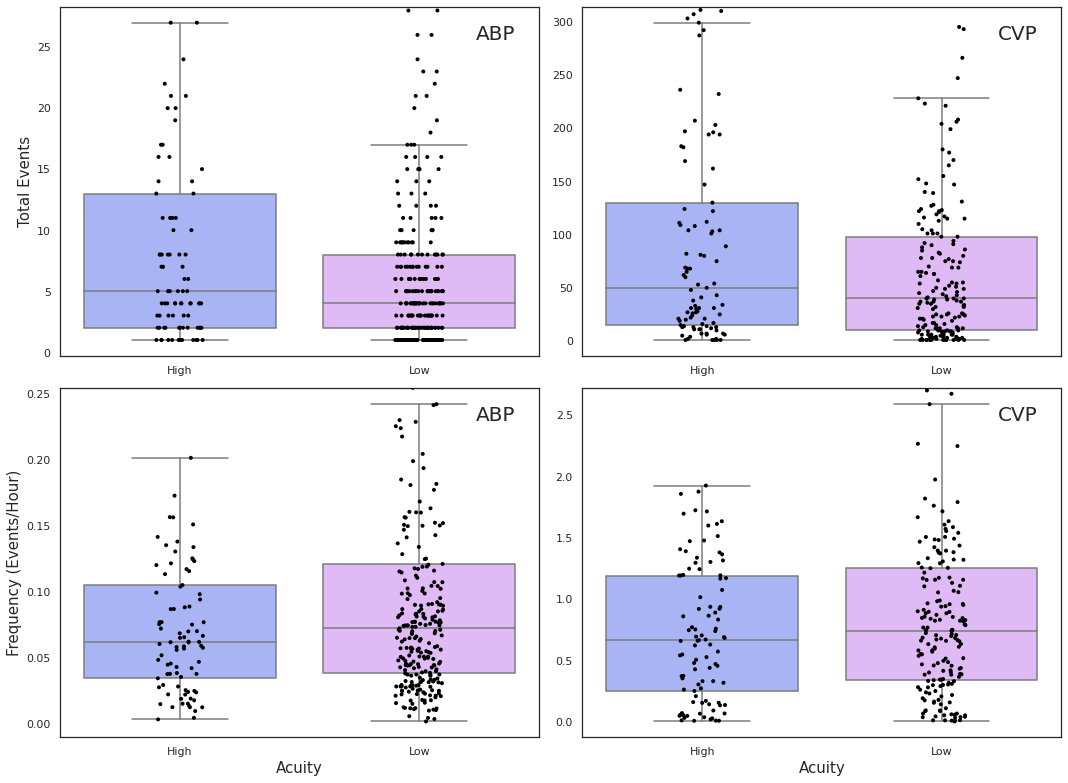

In [20]:
# Your initial setup remains unchanged
custom_titles = {
    'abp': '',
    'cvp': ''
}
#custom_xlabels = 'Start of Biweekly Period (MM-DD)'
custom_ylabels = {
    'NumPositives': 'Total Events',
    'Frequency': 'Frequency (Events/Hour)'
}
custom_legend_title = 'Acuity Level'

df = results_df  # Your DataFrame should be defined earlier in the code
x = "Acuity"

acuity_colors = {
    'High': '#9CACFF',
    'Low': '#E2B0FF'
}

sns.set(font="sans-serif")
sns.set_style("white")

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted for potentially better layout

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Loop through each metric and model combination
panel_labels = ["ABP", "CVP", "ABP", "CVP"]  # Example annotations
for idx, (y, model) in enumerate([('NumPositives', 'abp'), ('NumPositives', 'cvp'), ('Frequency', 'abp'), ('Frequency', 'cvp')]):
    ax = sns.boxplot(data=df[df["Model"]==model], 
                     x=x, y=y, showfliers=False, ax=axs[idx], palette=acuity_colors)
    ylims = ax.get_ylim()
    sns.stripplot(data=df[df["Model"]==model], 
                  x=x, y=y, color='black', size=4, jitter=True, dodge=True, ax=axs[idx])
    ax.set(ylim=ylims)
    if model == 'abp':
        ax.set_ylabel(custom_ylabels[y], fontsize=15)
    else:
        ax.set_ylabel('')
    ax.set_title(custom_titles[model])
    if y =="NumPositives":
        ax.set_xlabel('')
    else:

        ax.set_xlabel(x, fontsize=15)
    
    # Add annotation in the top right corner of each subplot
    ax.text(0.95, 0.95, panel_labels[idx], transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5))

# Adjust the layout and the rest of the code as before
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#handles, labels = axs[-1].get_legend_handles_labels()
#legend = fig.legend(handles[:2], labels[:2], loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3, title=custom_legend_title, handletextpad=0.5)
#legend.get_title().set_ha("center")
plt.savefig('prospective.pdf')
plt.show()


In [71]:
results_df.NumPositives.sum()

25084

In [53]:
def process_data_for_timestamp(epoch_timestamp, window_size, current_slide, new_slide, smoothing_method):
    patients = []
    all_measures = []
    models = []
    length_of_stays = []
    line_times = []
    acuities = []
    num_positives = []
    frequencies = []
    intervals = []
    last_accesses = []
    activity = []

    # Filter patient intervals for those overlapping with the given timestamp
    for patient_id, ((start, stop), measures, _) in tqdm(patient_intervals.items()):
        # Skip if the interval does not overlap with the given timestamp
        if not (int(start) <= epoch_timestamp <= int(stop)):
            continue

        # Determine bed and acuity from patient_id
        bed = patient_id.split('_')[0]
        acuity = "High" if bed in high_acuity else "Low"
        
        for model in ["abp", "cvp"]:
            for measure in measures:  # Load the right CSV
                if model_from_measure(measure) == model:
                    data_list = load_device(model, measure, window_size)[1:]  # remove header
                    
                    
                    # Filter for data before the given timestamp
                    data_list = [(a, b, c) for (a, b, c) in data_list if (int(a) >= int(start) and int(b) <= epoch_timestamp)]

                    if not data_list:
                        continue  # If no data before the timestamp, skip to the next measure
                    
                    if (epoch_timestamp - int(data_list[-1][1]))<60:
                        active = "Yes"
                    
                    else:
                        active = "No"

                    
                    
                    smoothed, _ = preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method)
                    pos_predictions, neg_predictions = stitch_predictions(smoothed, tolerance=30, threshold=0.5)
                    
                    pos_predictions = [(start,stop) for (start,stop) in pos_predictions if (epoch_timestamp-start)<24*60*60]
                    num_pos = len(pos_predictions)
                    
                    if num_pos >0:
                        
                        duration_pos = sum(min(epoch_timestamp, int(stop)) - int(start) for (start, stop) in pos_predictions if start < epoch_timestamp)
                        line_time = duration_pos + sum(min(epoch_timestamp, int(stop)) - int(start) for (start, stop) in neg_predictions if start < epoch_timestamp)

                        last_access = pos_predictions[-1][0]

                        if line_time > 10*60:
                       
                            freq = num_pos / (line_time/3600)  # Convert seconds to hours

                            patients.append(patient_id)
                            all_measures.append(measure)
                            models.append(model)
                            length_of_stays.append(stop-start)
                            line_times.append(line_time)
                            acuities.append(acuity)
                            num_positives.append(num_pos)
                            frequencies.append(freq)
                            intervals.append((start, stop))
                            last_accesses.append(last_access)
                            activity.append(active)
                else:
                    continue

    return pd.DataFrame({
        'patient': patients,
        'measures': all_measures,
        'model': models,
        'LOS': length_of_stays,
        'line_time': line_times,
        'acuity': acuities,
        'num_positive': num_positives,
        'frequency': frequencies,
        'interval': intervals,
        'last_access': last_accesses,
        'active': activity
    })



In [54]:
# Use the function like this:
epoch_timestamp = 1700483400  # Replace with your specific timestamp
snapshot_df = process_data_for_timestamp(epoch_timestamp, window_size, current_slide, new_slide, smoothing_method)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [01:03<00:00,  7.26it/s]


In [58]:

# Convert 'last_access' to human-readable format
snapshot_df['last_access_human'] = pd.to_datetime((snapshot_df['last_access']-7*60*60), unit='s')
snapshot_df['line_time_human'] = snapshot_df['line_time']/3600

snapshot_df

,patient,measures,model,LOS,line_time,acuity,num_positive,frequency,interval,last_access,active,last_access_human,line_time_human
0,84_8,84_MDC_PRESS_BLD_ATR_RIGHT,cvp,1882625,751145,High,3,0.014378,"(1698690250, 1700572875)",1700411115,Yes,2023-11-19 09:25:15,208.651389
1,85_3,85_MDC_PRESS_BLD_ATR_RIGHT,cvp,813651,319440,High,11,0.123967,"(1700079356, 1700893007)",1700467341,Yes,2023-11-20 01:02:21,88.733333
2,86_3,86_MDC_PRESS_BLD_ART,abp,711510,410280,High,3,0.026323,"(1700066719, 1700778229)",1700474149,Yes,2023-11-20 02:55:49,113.966667
3,86_3,86_MDC_PRESS_BLD_VEN_CENT,cvp,711510,254580,High,43,0.608060,"(1700066719, 1700778229)",1700481409,Yes,2023-11-20 04:56:49,70.716667
4,91_6,91_MDC_PRESS_BLD_VEN_CENT,cvp,146460,55380,High,3,0.195016,"(1700427586, 1700574046)",1700458006,Yes,2023-11-19 22:26:46,15.383333
5,92_13,92_MDC_PRESS_BLD_ART,abp,687560,474120,Low,2,0.015186,"(1699997911, 1700685471)",1700456311,Yes,2023-11-19 21:58:31,131.700000
6,113_6,113_MDC_PRESS_BLD_ART,abp,344100,137760,Low,2,0.052265,"(1700344165, 1700688265)",1700416705,Yes,2023-11-19 10:58:25,38.266667
7,109_3,109_MDC_PRESS_BLD_ATR_RIGHT,cvp,2119296,774190,Low,13,0.060450,"(1698773712, 1700893008)",1700431088,Yes,2023-11-19 14:58:08,215.052778
8,98_6,98_MDC_PRESS_BLD_VEN_CENT,cvp,711286,190740,Low,13,0.245360,"(1700155236, 1700866522)",1700457582,Yes,2023-11-19 22:19:42,52.983333
9,108_1,108_MDC_PRESS_BLD_ART,abp,1944042,1478340,Low,1,0.002435,"(1698948965, 1700893007)",1700436640,Yes,2023-11-19 16:30:40,410.650000


In [59]:

# Summary statistics
summary_stats = {
    'Total Patients with Lines': snapshot_df['patient'].nunique(),
    'Patients with ABP': snapshot_df[snapshot_df['model'] == 'abp']['patient'].nunique(),
    'Patients with CVP': snapshot_df[snapshot_df['model'] == 'cvp']['patient'].nunique(),
    'Total Unique Measures': snapshot_df.groupby('patient')['measures'].nunique().sum(),
    'Lines per Patient': snapshot_df.groupby('patient')['measures'].nunique() ,
    'Unique Measures per Patient ABP': snapshot_df[snapshot_df['model'] == 'abp'].groupby('patient')['measures'].nunique(),
    'Unique Measures per Patient CVP': snapshot_df[snapshot_df['model'] == 'cvp'].groupby('patient')['measures'].nunique(),
    'Number of Positives per Measure': snapshot_df.groupby(['patient','measures'])['num_positive'].sum(),
    'Time of Last Access': snapshot_df.groupby(['patient', 'measures'])['last_access_human'].max(),
    'Active Lines': snapshot_df.groupby(['patient', 'measures'])['active'].max(),
    'Line Time ': snapshot_df.groupby(['patient', 'measures'])['line_time_human'].max()
}

for key, values in summary_stats.items():
    print(key)
    print(values)


Total Patients with Lines
14
Patients with ABP
8
Patients with CVP
8
Total Unique Measures
16
Lines per Patient
patient
104_2     1
108_1     2
109_3     1
112_10    1
112_9     1
113_6     1
114_3     1
83_1      1
84_8      1
85_3      1
86_3      2
91_6      1
92_13     1
98_6      1
Name: measures, dtype: int64
Unique Measures per Patient ABP
patient
104_2     1
108_1     1
112_10    1
113_6     1
114_3     1
83_1      1
86_3      1
92_13     1
Name: measures, dtype: int64
Unique Measures per Patient CVP
patient
108_1    1
109_3    1
112_9    1
84_8     1
85_3     1
86_3     1
91_6     1
98_6     1
Name: measures, dtype: int64
Number of Positives per Measure
patient  measures                   
104_2    104_MDC_PRESS_BLD_ART           3
108_1    108_MDC_PRESS_BLD_ART           1
         108_MDC_PRESS_BLD_VEN_CENT      1
109_3    109_MDC_PRESS_BLD_ATR_RIGHT    13
112_10   112_MDC_PRESS_BLD_ART_ABP       2
112_9    112_MDC_PRESS_BLD_VEN_CENT     38
113_6    113_MDC_PRESS_BLD_ART    

In [62]:
month_start = 1706763600
month_end = 1709355599

total = 0

# Filter patient intervals for those overlapping with the given timestamp
for patient_id, ((start, stop), measures, _) in tqdm(patient_intervals.items()):
    
    
    if not((month_start<=start <=month_start) or (month_start<=stop <=month_start) or (start<=month_start <=stop)):
        continue

    # Determine bed and acuity from patient_id
    bed = patient_id.split('_')[0]

    for model in ["abp", "cvp"]:
        for measure in measures:  # Load the right CSV
            if model_from_measure(measure) == model:
                data_list = load_device(model, measure, window_size)[1:]  # remove header


                # Filter for data before the given timestamp
                data_list = [(a, b, c) for (a, b, c) in data_list if (int(a) >= int(start) and int(b) <= month_end)]

                if not data_list:
                    continue  # If no data before the timestamp, skip to the next measure


                smoothed, _ = preprocess_device(data_list, window_size, current_slide, new_slide, smoothing_method)
                pos_predictions, neg_predictions = stitch_predictions(smoothed, tolerance=30, threshold=0.5)

                pos_predictions = [(start,stop) for (start,stop) in pos_predictions if (month_start<=start <=month_end)]
                num_pos = len(pos_predictions)
                total+= num_pos


            else:
                continue




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [01:09<00:00,  6.65it/s]


In [64]:
total, total/60

(1912, 31.866666666666667)